# Global Counterfactuals with GLANCE

Builds a GLANCE explainer on the Moons dataset by clustering DiCE-based local actions into a compact set of global translation vectors.


**Requirements:** The GLANCE workflow depends on `dice-ml`. Make sure it is installed before running the counterfactual generation cells.


In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import dice_ml
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

import counterfactuals.cf_methods.local.dice as dice_module
from counterfactuals.cf_methods.group.glance.glance import GlobalGLANCE
from counterfactuals.datasets.file_dataset import FileDataset
from counterfactuals.models import LogisticRegression

/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class DiceExplainerWrapper:
    """Thin dice-ml wrapper compatible with GLANCE."""

    def __init__(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        features: list[str],
        model: LogisticRegression,
        *,
        method: str = "random",
    ) -> None:
        feature_names = list(features[:-1])
        target_name = str(features[-1])
        data_frame = pd.DataFrame(
            np.column_stack((X_train, y_train.reshape(-1, 1))),
            columns=feature_names + [target_name],
        )
        data = dice_ml.Data(
            dataframe=data_frame,
            continuous_features=feature_names,
            outcome_name=target_name,
        )
        dice_model = dice_ml.Model(model, backend="PYT")
        self._features = feature_names
        self._explainer = dice_ml.Dice(data, dice_model, method=method)

    def generate(self, query_instance: pd.DataFrame) -> np.ndarray | None:
        """Return a single counterfactual for the query instance if available."""
        dice_exp = self._explainer.generate_counterfactuals(
            query_instance,
            total_CFs=1,
            desired_class="opposite",
            stopping_threshold=0.5,
            posthoc_sparsity_param=0.1,
            posthoc_sparsity_algorithm="linear",
            verbose=False,
        )
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df.empty:
            return None
        return cf_df[self._features].to_numpy(dtype=np.float32)


dice_module.DiceExplainerWrapper = DiceExplainerWrapper

## Prepare data and dataloaders


In [4]:
torch.manual_seed(42)

dataset = FileDataset(config_path="../config/datasets/moons.yaml")

X_train = dataset.X_train.astype(np.float32)
X_test = dataset.X_test.astype(np.float32)
y_train = dataset.y_train.astype(np.int64)
y_test = dataset.y_test.astype(np.int64)

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32),
)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

## Train a discriminative model


In [14]:
num_features = X_train.shape[1]
disc_model = LogisticRegression(num_inputs=num_features, num_targets=1)
disc_model.fit(
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=2000,
    lr=0.01,
    patience=200,
    checkpoint_path="glance_checkpoint.pt",
)

Epoch 986, Train: 0.2605, test: 0.2769, patience: 200:  49%|████▉     | 986/2000 [00:03<00:03, 258.98it/s]


In [6]:
test_predictions = disc_model.predict(X_test)
test_accuracy = float((test_predictions == y_test).mean())
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.870


## Configure GLANCE and derive global actions


In [7]:
def predict_crisp(batch: np.ndarray) -> np.ndarray:
    values = np.asarray(batch, dtype=np.float32)
    if values.ndim == 1:
        values = values.reshape(1, -1)
    return disc_model.predict(values)


disc_model.predict_crisp = predict_crisp  # type: ignore[attr-defined]

glance = GlobalGLANCE(
    X_test=X_test,
    y_test=y_test,
    model=disc_model,
    features=dataset.features,
    k=10,
    s=4,
    m=1,
)
glance.prep(X_train, y_train)
len(glance.get_clusters())

0it [00:00, ?it/s]/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7034996621' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.64033045478' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
100%|██████████| 1/1 [00:00<00:00, 16.56it/s]
/Users/lukasz/genwro/counterfactual

4

## Inspect merged clusters


In [8]:
cluster_records = []
for centroid, label, action in glance.get_clusters():
    cluster_records.append(
        {
            "cluster_label": label,
            "centroid_feature_0": centroid[0],
            "centroid_feature_1": centroid[1],
            "action_feature_0": action[0],
            "action_feature_1": action[1],
        }
    )
pd.DataFrame(cluster_records)

,cluster_label,centroid_feature_0,centroid_feature_1,action_feature_0,action_feature_1
0,5,0.965903,0.362951,-1.477899,-0.866074
1,8,0.988433,0.036116,0.000000,1.038667
2,11,0.667581,0.754929,0.227303,-0.925919
3,15,-0.663398,0.527812,1.270094,-0.856526


## Apply global actions to build counterfactuals


In [9]:
original_candidates = X_test[y_test != 1]
counterfactual_candidates = glance.explain()
cf_predictions = disc_model.predict(counterfactual_candidates)

results = pd.DataFrame(
    {
        "original_feature_0": original_candidates[:, 0],
        "counterfactual_feature_0": counterfactual_candidates[:, 0],
        "delta_feature_0": counterfactual_candidates[:, 0] - original_candidates[:, 0],
        "original_feature_1": original_candidates[:, 1],
        "counterfactual_feature_1": counterfactual_candidates[:, 1],
        "delta_feature_1": counterfactual_candidates[:, 1] - original_candidates[:, 1],
        "original_prediction": test_predictions[y_test != 1],
        "counterfactual_prediction": cf_predictions,
    }
)
results.head()

,original_feature_0,counterfactual_feature_0,delta_feature_0,original_feature_1,counterfactual_feature_1,delta_feature_1,original_prediction,counterfactual_prediction
0,-0.806975,0.463118,1.270094,0.212149,-0.644376,-0.856526,0.0,1.0
1,-0.868728,0.401366,1.270094,0.028738,-0.827788,-0.856526,0.0,1.0
2,-0.588660,0.681433,1.270094,0.898283,0.041757,-0.856526,0.0,1.0
3,0.571200,0.798502,0.227303,0.791557,-0.134362,-0.925919,0.0,1.0
4,-0.743364,0.526730,1.270094,0.769703,-0.086823,-0.856526,0.0,1.0


In [10]:
## Calculate metrics for counterfactual quality

In [11]:
# Calculate validity (percentage of CFs that achieved the target class)
validity = (cf_predictions == 1).mean()
print(f"Validity: {validity:.3f}")

# Calculate average distance (L2 norm)
distances = np.linalg.norm(counterfactual_candidates - original_candidates, axis=1)
avg_distance = distances.mean()
print(f"Average L2 distance: {avg_distance:.3f}")

# Calculate sparsity (average number of features changed)
changes = np.abs(counterfactual_candidates - original_candidates) > 1e-6
sparsity = changes.sum(axis=1).mean()
print(f"Average sparsity (features changed): {sparsity:.3f}")

Validity: 0.929
Average L2 distance: 1.342
Average sparsity (features changed): 1.929


In [12]:
## Visualize counterfactuals

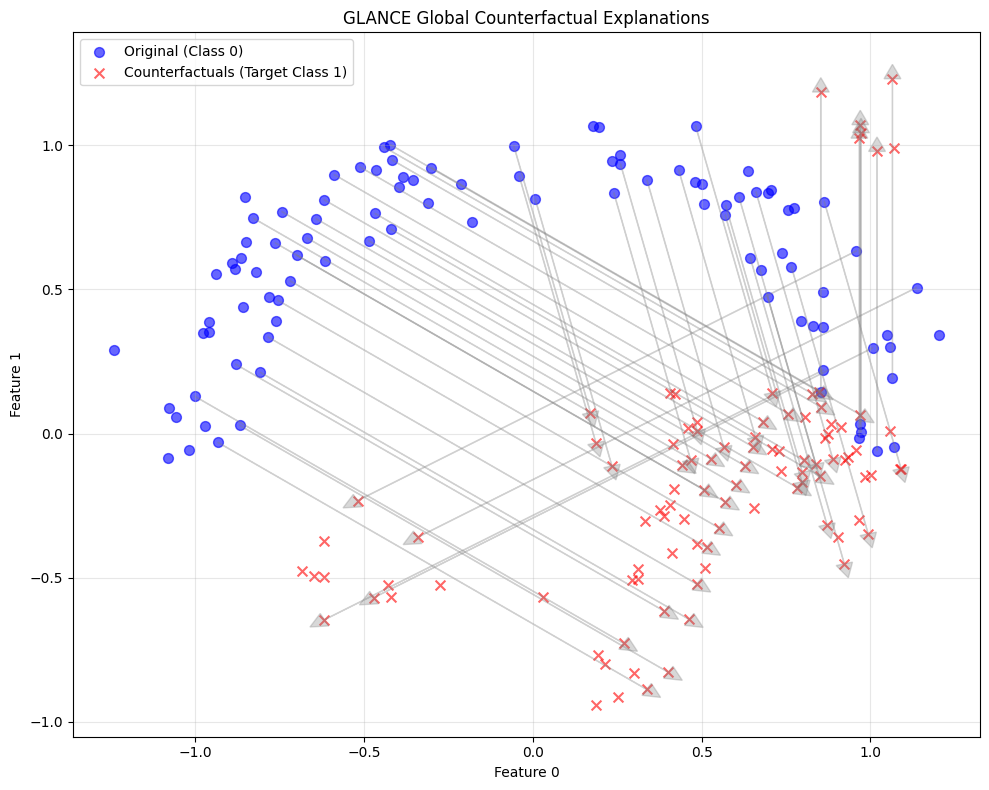

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

# Plot original instances (class 0 in blue)
ax.scatter(
    original_candidates[:, 0],
    original_candidates[:, 1],
    c="blue",
    marker="o",
    s=50,
    alpha=0.6,
    label="Original (Class 0)",
)

# Plot counterfactuals (should be class 1 in red)
ax.scatter(
    counterfactual_candidates[:, 0],
    counterfactual_candidates[:, 1],
    c="red",
    marker="x",
    s=50,
    alpha=0.6,
    label="Counterfactuals (Target Class 1)",
)

# Draw arrows showing the transformation
for i in range(min(50, len(original_candidates))):  # Limit to 50 arrows for clarity
    ax.arrow(
        original_candidates[i, 0],
        original_candidates[i, 1],
        counterfactual_candidates[i, 0] - original_candidates[i, 0],
        counterfactual_candidates[i, 1] - original_candidates[i, 1],
        head_width=0.05,
        head_length=0.05,
        fc="gray",
        ec="gray",
        alpha=0.3,
    )

ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_title("GLANCE Global Counterfactual Explanations")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()